In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
import sklearn

from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]

In [3]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index(drop=True)
keys = excel['Key']
L = get_filename_list(excel['Associated data'])

[3, 9]


In [4]:
x10_x17 = excel.iloc[:, 3:-3]
x10_x17.head()

,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI #,X17: CI
0,A,298.0,0,0,0,7.00,0,N
1,B,298.0,0,0,50,4.74,0,N
2,A,298.0,0,0,0,7.00,1,CI_2
3,A,298.0,0,0,0,7.00,2,CI_1
4,A,298.0,0,0,0,7.00,2,CI_2


In [5]:
master, master_names = prepare_master(x10_x17)

In [6]:
K = master

In [7]:
D = create_x6_matrix(L, max_dims=(50, 6))

In [8]:
# D = sklearn.preprocessing.normalize(D)
# D = sklearn.preprocessing.StandardScaler().fit_transform(D)
# K = sklearn.preprocessing.StandardScaler().fit_transform(K)

In [9]:
y = excel['Output: logK']
print(D.shape, y.shape)

(196, 300) (196,)


In [10]:
Gammas = [1e-4, 1e-2, 1e-1, 1, 10, 100, 'auto']
Cs = [0.1, 1, 10, 20, 50]
Epsilons = [1e-5, 1e-4, 1e-2, 1e-1, 1, 10]
num_directions = [1, 2, 3]
bandwidths = [1.0]
lims = [1, 2, 5, 7, 10]
up_lims = [1, 2, 5, 7, 10]
muls = [0.1, 1, 2, 3, 5, 10]
up_muls = [0.1, 1, 2, 3, 5, 10]

best_params = [0,0,0,0,0]
best_score = -float('inf')
best_cvs = None

up_lim = 0
up_mul = 0


clf = svm.SVR(kernel='rbf')
# sws = compute_sample_weights(y, lim=lim, mul=mul)
cvs = cross_val_score(clf, D, y, cv=5, scoring='neg_median_absolute_error')
print(cvs.mean())

-1.6200500839767922


In [11]:
results = []
for i in range(D.shape[0]):
    mask = np.ones(y.shape, dtype=bool)
    mask[i] = False
    y_train = y[mask]
    y_test = y[i]
    K_train = np.delete(K, i, axis=0)
    K_test = K[i].reshape(1,-1)
    D_train = np.delete(D, i, axis=0)
    D_test = D[i].reshape(1,-1)
    DD_train = np.hstack((D_train, K_train))
    DD_test = np.hstack((D_test, K_test))
    
    DD_train = D_train
    DD_test = D_test
    
#     sws = compute_sample_weights(y_train, lim=3, mul=1)
    
#     clf = KernelRidge(kernel='rbf', alpha=0.0001)
    clf = linear_model.LinearRegression()
#     clf = DecisionTreeRegressor()

#     clf.fit(D_train,y_train)
#     clf = svm.LinearSVR(C=.1, epsilon=0.1)
#     clf.fit(DD_train,y_train, sample_weight=sws)
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    results.append({'predicted':prediction[0], 'actual':y_test, 'key':keys[i]})

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [12]:
res_df = pd.DataFrame(results)
print(np.median(np.abs(res_df['predicted'] - res_df['actual'])))
res_df.tail(20)

2.320108268260955


,actual,key,predicted
176,7.14,199,1.074344e+10
177,6.83,200,4.373845e+00
178,5.95,201,-5.685879e+09
179,6.20,202,-3.225755e+09
180,5.11,203,1.363404e+10
181,5.93,204,1.139131e+08
182,4.30,207,3.953109e+08
183,9.71,208,2.341371e+10
184,10.78,209,1.010261e+00
185,8.23,210,-1.122354e+01


In [13]:
res_df = res_df[(res_df['predicted'] < 20) & (res_df['predicted'] > -10)]

In [14]:
# print(np.median(np.abs(res_df['predicted'] - res_df['actual'])))

Text(0,0.5,'Predicted logK')

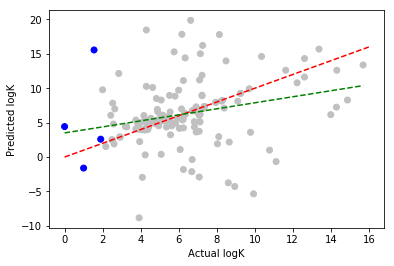

In [15]:
colors = ['blue' if (row['actual'] < 2) else 'orange' if row['key'] == 216 else 'silver' for idx, row in res_df.iterrows()]
plt.scatter(res_df['actual'], res_df['predicted'], color=colors)
plt.plot([0,16],[0,16], 'r--')
plt.plot(np.unique(res_df['actual']), np.poly1d(np.polyfit(res_df['actual'], res_df['predicted'], 1))(np.unique(res_df['actual'])), 'g--')
plt.xlabel('Actual logK')
plt.ylabel('Predicted logK')

In [16]:
# res_df.to_csv('quick_dump.csv')